<a href="https://colab.research.google.com/github/stepanjaburek/quantum_social_science_lr/blob/main/new_stepan_colab_pca_cluster_3.1.25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data wrangling

#Setup

In [ ]:
!pip install scikit-learn-extra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from IPython.display import display

data = pd.read_csv("/content/0_kw_analysis.csv")
metadata = pd.read_excel("/content/pdf_list(1).xlsx")

#Data cleaning

In [ ]:
# Rename "Broekaert_2018" in metadata
metadata.loc[252, 'file_name'] = "Broekaert_2018_The Tacit 'Quantum' of Meeting the Aesthetic Sign; Contextualize, Entangle,2.pdf"
data.loc[252, 'filename'] = "Broekaert_2018_The Tacit 'Quantum' of Meeting the Aesthetic Sign; Contextualize, Entangle,2.pdf"
# Delete duplicit paper "Yukalov et al. - 2018 - Information processing by networks of quantum deci.pdf"
data = data.drop(1170)
# Delete paper "Yilmaz - 2017 - Quantum cognition models of ethical decision-makin.pdf" that is only present in data
data = data.drop(1166)
# Delete paper "Park_2016_Decision-making &amp quantum mechanical models of cognitive processing.pdf" that is only present in metadata
metadata = metadata.drop(892)

# Keywords

In [ ]:
# Exclude authors and create df
df = data.drop(columns=[data.columns[i] for i in [1,2,4,16,30]])
# Exclude social science fields
df = df.drop(columns=df.columns[26:38])
# Possibly also Exclude "quantum" and "quantization"
df = df.drop(columns=df.columns[17:19])

# keep only papers with some non-zero values in the final columns we want to keep
df = df[df.iloc[:, 2:24].sum(axis=1) > 0]
df = df.reset_index(drop=True)

In [ ]:
[(i, list(df.keys())[i]) for i in range(len(df.keys()))]

In [ ]:
# Or keeep only the authors
#df = data[data.columns[[1,2,4,16,30]]]

# Numbering the data for centroid extraction

In [ ]:
metadata = metadata.reset_index()
metadata = metadata.rename(columns={'index': 'id'})
metadata['id'] = metadata['id'] + 1

df = df.reset_index()
df = df.rename(columns={'index': 'id'})
df['id'] = df['id'] + 1

# Scaling

In [ ]:
# create features for the pca
features = df.drop(['filename', 'id'], axis=1)
feature_names = features.columns

# scale with either z-score standardization or MinMax normalization
# features = StandardScaler().fit_transform(features) #Z-score
# features = MinMaxScaler().fit_transform(features) # MinMax

#features.iloc[:, 1:23] = (features.iloc[:, 1:23] > 0).astype(int) # binary >0
#features.iloc[:, 1:23] = (features.iloc[:, 1:23] > 4).astype(int) # binary >4

features = pd.DataFrame(features, columns=feature_names)
features

# Data analysis

#PCA

Explained variance ratio: [0.17363176 0.09995528 0.06639214 0.06459228 0.05995301]


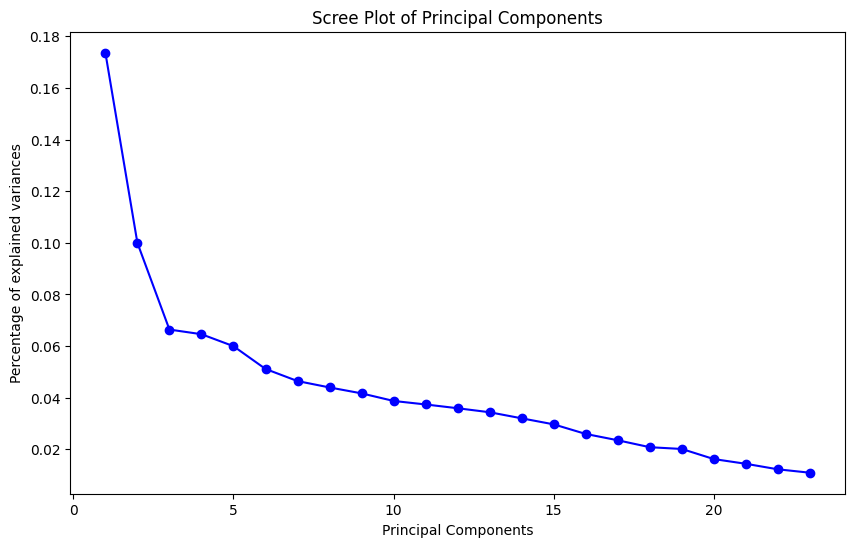

                     feature    PC   loading
operator            operator   PC1  0.332849
superposition  superposition   PC1  0.300056
wave function  wave function   PC1  0.271217
hilbert space  hilbert space   PC1  0.269126
eigenvalue        eigenvalue   PC1  0.264622
...                      ...   ...       ...
eigenvalue        eigenvalue  PC23  0.693004
operator            operator  PC23 -0.500308
eigenvector      eigenvector  PC23 -0.419465
collapse            collapse  PC23 -0.179188
wave function  wave function  PC23  0.160584

[115 rows x 3 columns]
                                     feature   PC   loading
operator                            operator  PC1  0.332849
superposition                  superposition  PC1  0.300056
wave function                  wave function  PC1  0.271217
hilbert space                  hilbert space  PC1  0.269126
eigenvalue                        eigenvalue  PC1  0.264622
eigenvalue                        eigenvalue  PC2  0.361304
operator        

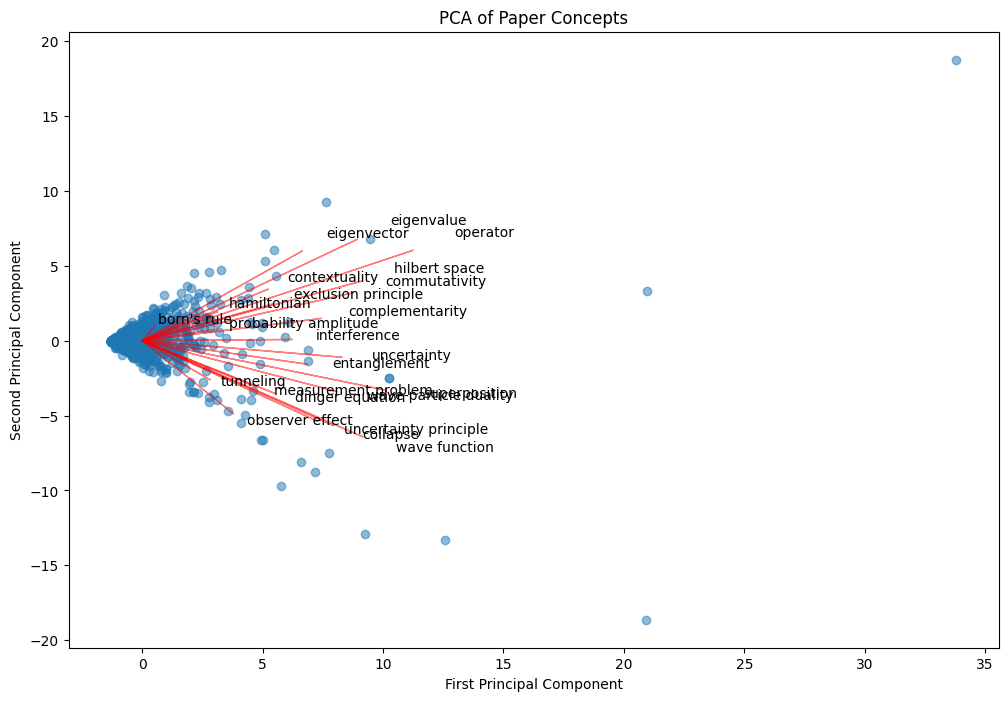

,feature,PC,loading
operator,operator,PC1,0.332849
superposition,superposition,PC1,0.300056
wave function,wave function,PC1,0.271217
hilbert space,hilbert space,PC1,0.269126
eigenvalue,eigenvalue,PC1,0.264622
eigenvalue,eigenvalue,PC2,0.361304
operator,operator,PC2,0.321937
eigenvector,eigenvector,PC2,0.319777
collapse,collapse,PC2,-0.303101
wave function,wave function,PC2,-0.342733


In [ ]:
pca = PCA()
pca_result = pca.fit_transform(features)
print("Explained variance ratio:", pca.explained_variance_ratio_[:5])

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, 'bo-')
plt.title('Scree Plot of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Percentage of explained variances')
plt.show()

# Feature importance in components
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features.columns
)

# Top 5 features per component
top_loadings = pd.DataFrame()
for pc in loadings.columns:
    top_5 = pd.DataFrame({
        'feature': loadings.index,
        'PC': pc,
        'loading': loadings[pc]
    })

    top_5 = top_5.reindex(top_5['loading'].abs().sort_values(ascending=False).index)
    top_5 = top_5.head(5)
    top_loadings = pd.concat([top_loadings, top_5])

print(top_loadings)

# PC1 and 2
pc12_loadings = top_loadings[top_loadings['PC'].isin(['PC1', 'PC2', 'PC3', 'PC4'])]
pc12_loadings = pc12_loadings.sort_values(['PC', 'loading'],
                                         ascending=[True, False])
print(pc12_loadings)

# PCA biplot
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

for i, feature in enumerate(features.columns):
    plt.arrow(0, 0,
              pca.components_[0, i]*max(abs(pca_result[:, 0])),
              pca.components_[1, i]*max(abs(pca_result[:, 1])),
              color='r', alpha=0.5)
    plt.text(pca.components_[0, i]*max(abs(pca_result[:, 0]))*1.15,
             pca.components_[1, i]*max(abs(pca_result[:, 1]))*1.15,
             feature)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Paper Concepts')
plt.show()
display(pc12_loadings)

# K-means cluster analysis

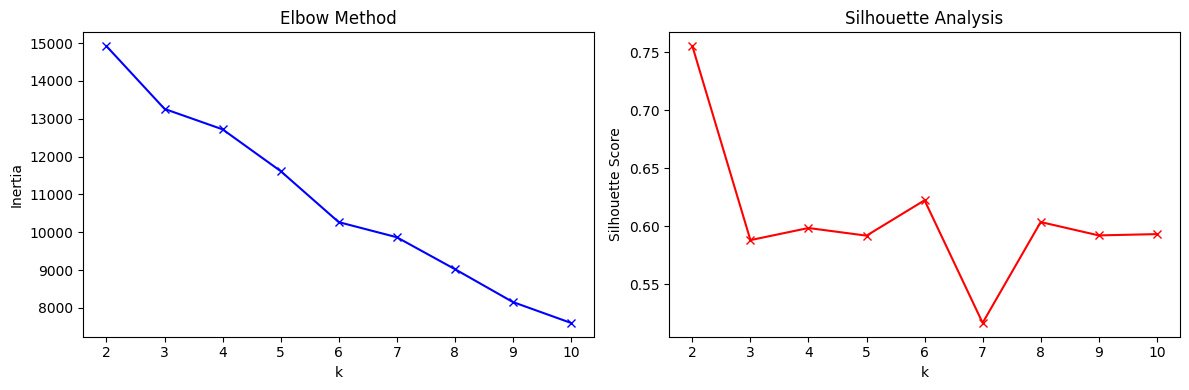

In [ ]:
from sklearn.metrics import silhouette_score

def optimize_kmeans(data, max_clusters=10):
    silhouette_scores = []
    inertias = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))
        inertias.append(kmeans.inertia_)

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(range(2, max_clusters + 1), inertias, 'bx-')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')

    ax2.plot(range(2, max_clusters + 1), silhouette_scores, 'rx-')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')

    plt.tight_layout()
    plt.show()

    return silhouette_scores, inertias

# Use on your data
scores, inertias = optimize_kmeans(pca_result[:, :9])

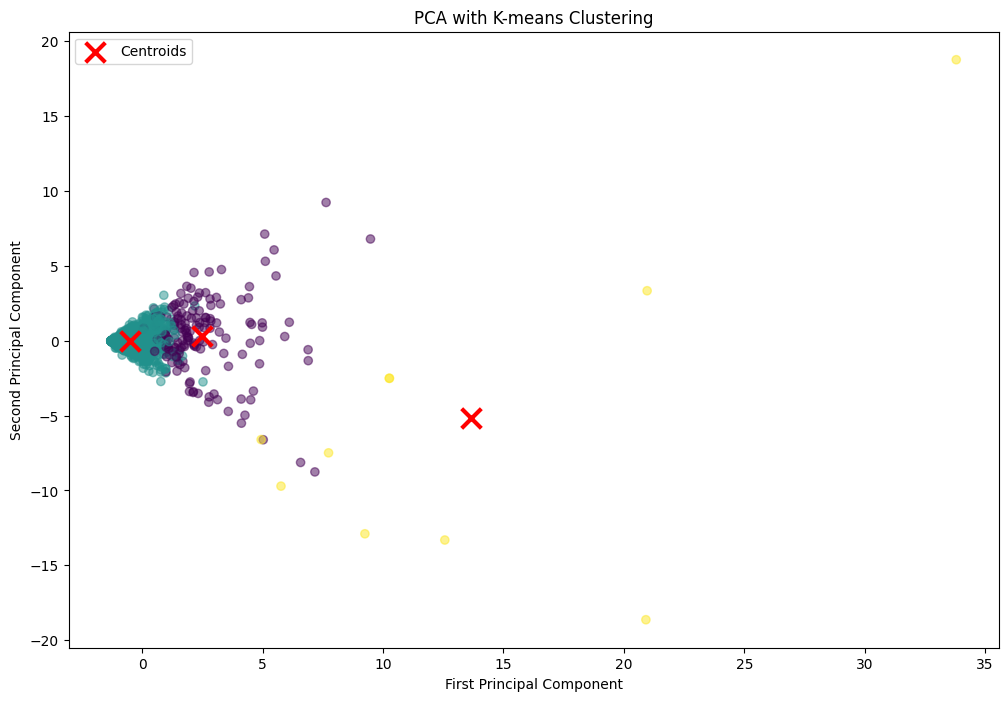

In [ ]:
# Key parameters to alter
######################
n_clusters = 3 # number of clusters
kmeans = KMeans(n_clusters=n_clusters,
                random_state=42)
cluster_labels = kmeans.fit_predict(pca_result[:, :5]) # number of dimensions in the analysis

# Get the centroids
centroid_coords = kmeans.cluster_centers_

# Function to get top papers for each centroid
def get_top_papers(centroid_coord, pca_data, df, cluster_num, n_top=10): # number of central papers to extarct
    distances = np.sum((pca_data - centroid_coord)**2, axis=1)
    top_indices = np.argsort(distances)[:n_top]
    return pd.DataFrame({
        'cluster': [cluster_num + 1] * n_top,
        'rank': range(1, n_top + 1),
        'centroid_id': df['id'].iloc[top_indices].values,
        'distance': distances[top_indices]
    })

# Get top papers for each centroid
centroids_list = []
for i in range(n_clusters):
    cluster_papers = get_top_papers(centroid_coords[i], pca_result[:, :5], df, i) # here as well number of dimensions in the analysis
    centroids_list.append(cluster_papers)

centroids = pd.concat(centroids_list, ignore_index=True)

centerpapers = pd.merge(centroids, metadata, left_on='centroid_id', right_on='id', how='left')
centerpapers.to_csv('center_papers_means.csv', index=False)

# Viz
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
           c='red', marker='x', s=200, linewidths=3, label='Centroids')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA with K-means Clustering')
plt.legend()
plt.show()

# K-medoids cluster analysis

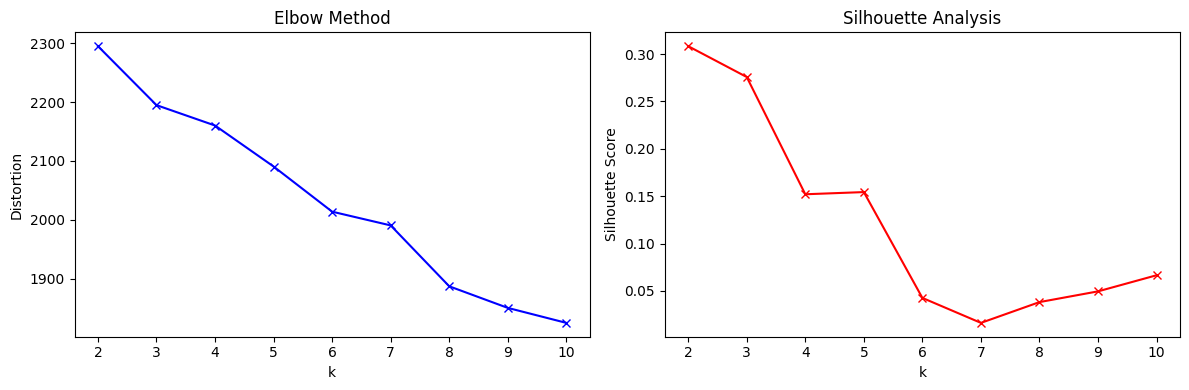

In [ ]:
def find_optimal_clusters(data, max_clusters=10):
    # Store results
    silhouette_scores = []
    distortions = []

    # Try different numbers of clusters
    for k in range(2, max_clusters + 1):
        # Initialize and fit KMedoids
        pam = KMedoids(n_clusters=k,
                       random_state=42,
                       metric='euclidean',
                       method='alternate')

        # Fit the model and get labels
        labels = pam.fit_predict(data)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)

        # Calculate distortion (within-cluster sum of squares)
        distortions.append(pam.inertia_)

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Elbow plot
    ax1.plot(range(2, max_clusters + 1), distortions, 'bx-')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Distortion')
    ax1.set_title('Elbow Method')

    # Silhouette plot
    ax2.plot(range(2, max_clusters + 1), silhouette_scores, 'rx-')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')

    plt.tight_layout()
    plt.show()

    return silhouette_scores, distortions

# Use on your data
scores, distortions = find_optimal_clusters(pca_result[:, :8]) # number of dimensions taken into account while clustering

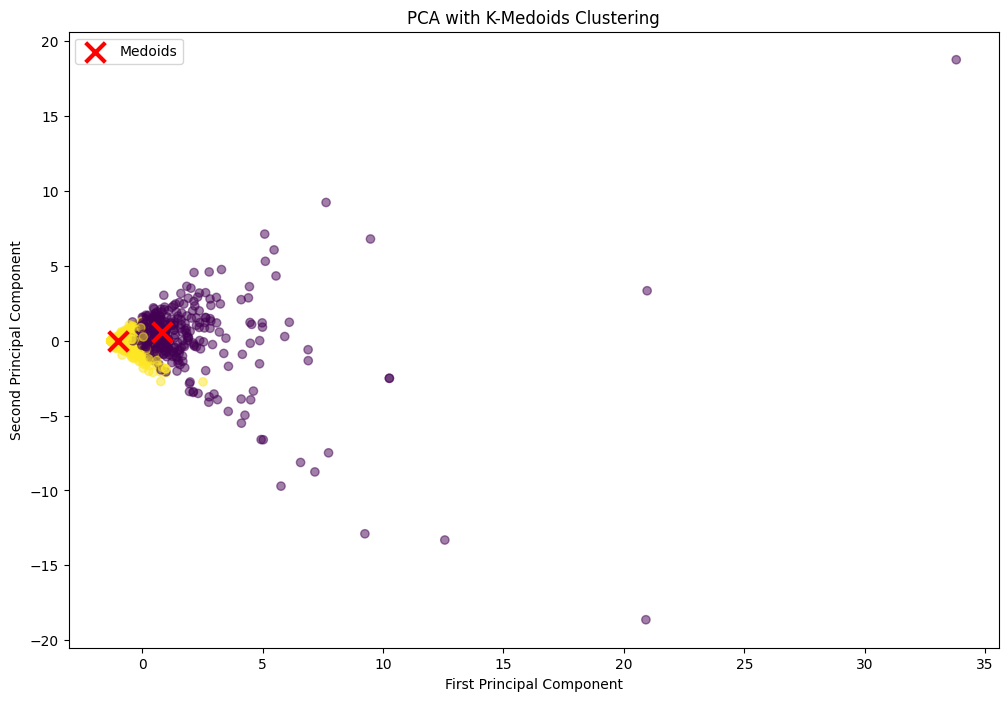

In [ ]:
# Key parameters to alter
######################
n_clusters = 2 # number of clusters
pam = KMedoids(n_clusters=n_clusters,
               random_state=42,
               metric='euclidean',
               method='alternate')
cluster_labels = pam.fit_predict(pca_result[:, :5]) # number of dimensions in the analysis

# Get the medoid coordinates
medoid_indices = pam.medoid_indices_
medoid_coords = pca_result[medoid_indices, :5] # here as well number of dimensions in the analysis

# Function to get top papers for each centroid
def get_top_papers(centroid_coord, pca_data, df, n_top=10): # number of central papers to extarct
    distances = np.sum((pca_data - centroid_coord)**2, axis=1)
    top_indices = np.argsort(distances)[:n_top]
    return pd.DataFrame({
        'cluster': [pam.medoid_indices_.tolist().index(medoid_indices[i]) + 1] * n_top,
        'rank': range(1, n_top + 1),
        'centroid_id': df['id'].iloc[top_indices].values,
        'distance': distances[top_indices]
    })

# Get top papers for each centroid
centroids_list = []
for i, medoid_coord in enumerate(medoid_coords):
    cluster_papers = get_top_papers(medoid_coord, pca_result[:, :5], df)
    centroids_list.append(cluster_papers)

centroids = pd.concat(centroids_list, ignore_index=True)

centerpapers = pd.merge(centroids, metadata, left_on='centroid_id', right_on='id', how='left')
centerpapers.to_csv('center_papers_medoids.csv', index=False)

# Viz
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)

# Plot medoids instead of kmeans centroids
plt.scatter(pca_result[medoid_indices, 0], pca_result[medoid_indices, 1],
           c='red', marker='x', s=200, linewidths=3, label='Medoids')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA with K-Medoids Clustering')
plt.legend()
plt.show()

# Overlap of clusters
only limited use for now, but this should be extendable to anything else

In [ ]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

# Binary K-means



In [ ]:
n_clusters = 3
dims = [2, 3, 4, 5, 10]
b3means2, b3means3,b3means4, b3means5, b3means10 = [
    KMeans(n_clusters=n_clusters, random_state=42).fit_predict(pca_result[:, :d])
    for d in dims
]

In [ ]:
import numpy as np

labels_dict = {
    '2 dims': b3means2,
    '3 dims': b3means3,
    '4 dims': b3means4,
    '5 dims': b3means5,
    '10 dims': b3means10
}

n = len(labels_dict)
ari_matrix = pd.DataFrame(np.zeros((n, n)),
                         columns=labels_dict.keys(),
                         index=labels_dict.keys())

for i in labels_dict.keys():
    for j in labels_dict.keys():
        ari = adjusted_rand_score(labels_dict[i], labels_dict[j])
        ari_matrix.loc[i,j] = round(ari, 3)

print("Adjusted Rand Index Scores between different dimensionalities:")
print(ari_matrix)

# ARI goes from -1 to 1 and measures the similarity between 2 clustering mechanisms

Adjusted Rand Index Scores between different dimensionalities:
         2 dims  3 dims  4 dims  5 dims  10 dims
2 dims    1.000   0.804   0.908   0.784    0.776
3 dims    0.804   1.000   0.849   0.648    0.687
4 dims    0.908   0.849   1.000   0.749    0.748
5 dims    0.784   0.648   0.749   1.000    0.828
10 dims   0.776   0.687   0.748   0.828    1.000


# Z-Score K-means

In [ ]:
n_clusters = 3
dims = [2, 3, 4, 5, 10]
z3means2, z3means3,z3means4, z3means5, z3means10 = [
    KMeans(n_clusters=n_clusters, random_state=42).fit_predict(pca_result[:, :d])
    for d in dims
]

In [ ]:
import numpy as np

labels_dict = {
    '2 dims': z3means2,
    '3 dims': z3means3,
    '4 dims': z3means4,
    '5 dims': z3means5,
    '10 dims': z3means10
}

n = len(labels_dict)
ari_matrix = pd.DataFrame(np.zeros((n, n)),
                         columns=labels_dict.keys(),
                         index=labels_dict.keys())

for i in labels_dict.keys():
    for j in labels_dict.keys():
        ari = adjusted_rand_score(labels_dict[i], labels_dict[j])
        ari_matrix.loc[i,j] = round(ari, 3)

print("Adjusted Rand Index Scores between different dimensionalities:")
print(ari_matrix)

Adjusted Rand Index Scores between different dimensionalities:
         2 dims  3 dims  4 dims  5 dims  10 dims
2 dims    1.000   0.804   0.908   0.784    0.776
3 dims    0.804   1.000   0.849   0.648    0.687
4 dims    0.908   0.849   1.000   0.749    0.748
5 dims    0.784   0.648   0.749   1.000    0.828
10 dims   0.776   0.687   0.748   0.828    1.000


# MinMax K-Means

In [ ]:
n_clusters = 3
dims = [2, 3, 4, 5, 10]
m3means2, m3means3,m3means4, m3means5, m3means10 = [
    KMeans(n_clusters=n_clusters, random_state=42).fit_predict(pca_result[:, :d])
    for d in dims
]

In [ ]:
import numpy as np

labels_dict = {
    '2 dims': m3means2,
    '3 dims': m3means3,
    '4 dims': m3means4,
    '5 dims': m3means5,
    '10 dims': m3means10
}

n = len(labels_dict)
ari_matrix = pd.DataFrame(np.zeros((n, n)),
                         columns=labels_dict.keys(),
                         index=labels_dict.keys())

for i in labels_dict.keys():
    for j in labels_dict.keys():
        ari = adjusted_rand_score(labels_dict[i], labels_dict[j])
        ari_matrix.loc[i,j] = round(ari, 3)

print("Adjusted Rand Index Scores between different dimensionalities:")
print(ari_matrix)

Adjusted Rand Index Scores between different dimensionalities:
         2 dims  3 dims  4 dims  5 dims  10 dims
2 dims    1.000   0.538   0.759   0.798    0.777
3 dims    0.538   1.000   0.684   0.581    0.678
4 dims    0.759   0.684   1.000   0.842    0.968
5 dims    0.798   0.581   0.842   1.000    0.844
10 dims   0.777   0.678   0.968   0.844    1.000


In [ ]:
from IPython.display import display
display(ari_matrix)

,2 dims,3 dims,4 dims,5 dims,10 dims
2 dims,1.000,0.398,0.856,0.146,0.106
3 dims,0.398,1.000,0.498,0.038,0.027
4 dims,0.856,0.498,1.000,0.111,0.080
5 dims,0.146,0.038,0.111,1.000,0.826
10 dims,0.106,0.027,0.080,0.826,1.000


# Z-score K-Medoids

In [ ]:
n_clusters = 2
dims = [2, 3, 4, 5, 10]
z3medoids2, z3medoids3, z3medoids4, z3medoids5, z3medoids10 = [
    KMedoids(n_clusters=n_clusters, random_state=42, metric='euclidean',
             method='alternate').fit_predict(pca_result[:, :d])
    for d in dims
]

In [ ]:
import numpy as np

labels_dict = {
    '2 dims': z3medoids2,
    '3 dims': z3medoids3,
    '4 dims': z3medoids4,
    '5 dims': z3medoids5,
    '10 dims': z3medoids10
}

n = len(labels_dict)
ari_matrix = pd.DataFrame(np.zeros((n, n)),
                         columns=labels_dict.keys(),
                         index=labels_dict.keys())

for i in labels_dict.keys():
    for j in labels_dict.keys():
        ari = adjusted_rand_score(labels_dict[i], labels_dict[j])
        ari_matrix.loc[i,j] = round(ari, 3)

print("Adjusted Rand Index Scores between different dimensionalities:")
print(ari_matrix)

Adjusted Rand Index Scores between different dimensionalities:
         2 dims  3 dims  4 dims  5 dims  10 dims
2 dims    1.000   0.463   0.730   0.632    0.354
3 dims    0.463   1.000   0.458   0.388    0.469
4 dims    0.730   0.458   1.000   0.554    0.369
5 dims    0.632   0.388   0.554   1.000    0.372
10 dims   0.354   0.469   0.369   0.372    1.000


In [ ]:
from IPython.display import display
display(ari_matrix)

,2 dims,3 dims,4 dims,5 dims,10 dims
2 dims,1.000,0.463,0.730,0.632,0.354
3 dims,0.463,1.000,0.458,0.388,0.469
4 dims,0.730,0.458,1.000,0.554,0.369
5 dims,0.632,0.388,0.554,1.000,0.372
10 dims,0.354,0.469,0.369,0.372,1.000


# Comparing Z-scores, MinMax, Binary




In [ ]:
# Compare each dimensionality pair
comparisons = {
   '2 dims': adjusted_rand_score(z3means2, b3means2),
   '3 dims': adjusted_rand_score(z3means3, b3means3),
   '4 dims': adjusted_rand_score(z3means4, b3means4),
   '5 dims': adjusted_rand_score(z3means5, b3means5),
   '10 dims': adjusted_rand_score(z3means10, b3means10)
}

# Create DataFrame
comparison_df = pd.DataFrame.from_dict(comparisons, orient='index', columns=['ARI Score'])
print("KMeans vs KMedoids comparison at different dimensions:")
print(comparison_df)

KMeans vs KMedoids comparison at different dimensions:
         ARI Score
2 dims    0.017464
3 dims    0.003694
4 dims    0.007661
5 dims    0.026209
10 dims   0.089356


In [ ]:
# Compare each dimensionality pair
comparisons = {
   '2 dims': adjusted_rand_score(m3means2, b3means2),
   '3 dims': adjusted_rand_score(m3means3, b3means3),
   '4 dims': adjusted_rand_score(m3means4, b3means4),
   '5 dims': adjusted_rand_score(m3means5, b3means5),
   '10 dims': adjusted_rand_score(m3means10, b3means10)
}

# Create DataFrame
comparison_df = pd.DataFrame.from_dict(comparisons, orient='index', columns=['ARI Score'])
print("KMeans vs KMedoids comparison at different dimensions:")
print(comparison_df)

KMeans vs KMedoids comparison at different dimensions:
         ARI Score
2 dims    0.040789
3 dims    0.006966
4 dims    0.017969
5 dims    0.028403
10 dims   0.066180


In [ ]:
# Compare each dimensionality pair
comparisons = {
   '2 dims': adjusted_rand_score(m3means2, z3means2),
   '3 dims': adjusted_rand_score(m3means3, z3means3),
   '4 dims': adjusted_rand_score(m3means4, z3means4),
   '5 dims': adjusted_rand_score(m3means5, z3means5),
   '10 dims': adjusted_rand_score(m3means10, z3means10)
}

# Create DataFrame
comparison_df = pd.DataFrame.from_dict(comparisons, orient='index', columns=['ARI Score'])
print("KMeans vs KMedoids comparison at different dimensions:")
print(comparison_df)

KMeans vs KMedoids comparison at different dimensions:
         ARI Score
2 dims    0.599007
3 dims    0.610429
4 dims    0.621733
5 dims    0.719408
10 dims   0.680496


In [ ]:
display(comparison_df)

,ARI Score
2 dims,0.599007
3 dims,0.610429
4 dims,0.621733
5 dims,0.719408
10 dims,0.680496
